In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
# A couple utility functions to plot grayscale 28x28 image:

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [3]:

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")
  

# Autoencoders

In [4]:
# Autoencoders are types of machine learning algorithms that seek to learn the patterns in data to reproduce that data using these learned patterns.
# Examples are software that can generate faces, popular music, paintings, etc...
# To find the fundamental patterns, of the data, mathematically, there is a process of dimensionality reduction that is used.

# PCA with a linear Autoencoder

In [5]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [6]:
# Normalize the data:


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [7]:
# Now let's build the Autoencoder:

import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()


/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWarnin

In [8]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

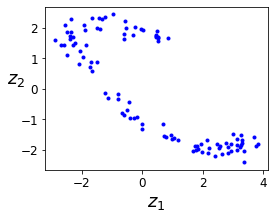

In [9]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.savefig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

In [10]:
# Stacked Autoencoders are multiple encoders joined together to improve accuracy by allowing the autoencoder to learn more complex encodings.
# There are different ways to train the stack of autoencoders.

# First, let's import MNIST data to train on:

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


# Train Stacked Autoencoder layers at once

In [11]:
# We will build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, HE initialization and L2 regularization:

reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

In [12]:
# Now let's train the model. Note that we don't feed target values (y_batch is not used). This is supervised training.

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")                  # not shown

0 Train MSE: 0.020987533
1 Train MSE: 0.011441894
2 Train MSE: 0.010220509
3 Train MSE: 0.009898585
4 Train MSE: 0.010376164


In [13]:
# This function loads the model, evaluates it on the test set (it measures the reconstruction error), then it displays the original image and its reconstruction:

def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


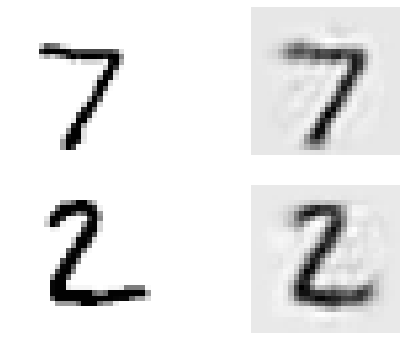

In [14]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
plt.savefig("reconstruction_plot")

# Tying Weights



In [15]:
# When an autoencoder is symmetrical, it is a common technique to tie the weights of the decoder layers to the weights of the encoder layers.
# This halves the number of weights in the model, speeding up training and reducing the risk of overfitting.

# Unfortunately, implementing tied weights in TensorFlow makes using the dense() function cumbersome.
# It is easier to build the Autoencoder manually:

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [16]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3") # tied weights
weights4 = tf.transpose(weights1, name="weights4") # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [17]:
saver = tf.train.Saver()

In [18]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.015066671
1 Train MSE: 0.016488358
2 Train MSE: 0.017375689
3 Train MSE: 0.016878145
4 Train MSE: 0.015587544


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


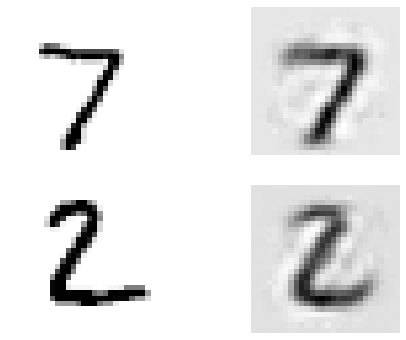

In [19]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

# Training one Autoencoder at a time in multiple graphs

In [20]:
# Rather than training the whole stacked encoder at once,
# It is often much faster to train one shallow encoder at a time,
# Then stack all of them into a single stacked autoencoder.
# This is especially useful for deep autoencoders.



In [21]:
# During the first phase of training, the first autoencoder learns to reconstruct the inputs.
# During the second phase, the second autoencoder learns to reconstruct the output of the first autoencoder's hidden layer.
# Finally, you combine(ie, first you stack the hidden layers of each autoencoder, then the output layers in reverse order).



In [22]:
# There are many ways to train one Autoencoder at a time. The first approach is to train each Autoencoder using a different graph,
# Then we create the Stacked Autoencoder by simply initializing it with the weights and biases copied from these Autoencoders.

# Let's create a function that will train one autoencoder and return the transformed training set and model parameters.

reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                     learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                     hidden_activation=tf.nn.elu,
                     output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)
        
        n_inputs = X_train.shape[1]
        
        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))
        
        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")
        
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
        
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)
        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        
        init = tf.global_variables_initializer()
        
    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]
                
            

In [23]:
# Now let's train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output:

hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150, output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.0185175
1 Train MSE: 0.018682454
2 Train MSE: 0.01846751
3 Train MSE: 0.019231487
0 Train MSE: 0.0042361016
1 Train MSE: 0.0048326678
2 Train MSE: 0.0046687284
3 Train MSE: 0.004403899


In [24]:
# Finally, we create a Stacked Encoder by simply reusing the weights and biases from the Autoencoders we just trained:

reset_graph()

n_inputs = 28 * 28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

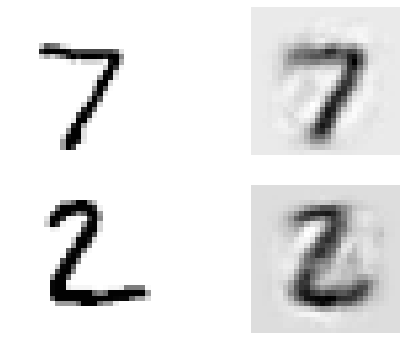

In [25]:
show_reconstructed_digits(X, outputs)

# Training one Autoencoder at a time in a single graph

In [26]:
# Another approach is to use a single graph.
# To do this, we create the graph for the full Stacked Autoencoder.
# But then we also add operations to train each Autoencoder independently:
    # Phase 1 trains the bottom and top layer (ie. the first Autoencoder)
    # Phase 2 trains the two middle layers (ie. the second Autoencoder)
    
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4 # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)
    
with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [28]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [29]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
        loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
        print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.007406794
1 Train MSE: 0.007828663
2 Train MSE: 0.0077280253
3 Train MSE: 0.007408932
Test MSE: 0.10571471
Training phase #2
0 Train MSE: 0.4187721
1 Train MSE: 0.0066193673
2 Train MSE: 0.0031084241
3 Train MSE: 0.0024261232
Test MSE: 0.0097884685


# Cache the frozen layer outputs

In [30]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)
                

Training phase #1
0 Train MSE: 0.0075381654
1 Train MSE: 0.0077545666
2 Train MSE: 0.0073435875
3 Train MSE: 0.007837683
Training phase #2
0 Train MSE: 0.2143637
1 Train MSE: 0.004208874
2 Train MSE: 0.0024039664
3 Train MSE: 0.0020118433
Test MSE: 0.009765391


# Visualizing the Reconstructions

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


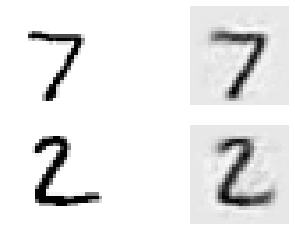

In [31]:
# One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs.
# They must be fairly similar, and the differences should be unimportant details. 
# Let's plot two random digits and their reconstructions:

n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})
    
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

# Visualizing the extracted features

In [32]:
# Once the autoencoder has learned some features, you might want to take a look at them.
# There are various techniques. The simplest technique is to consider each neuron in every hidden layer, and find the training instancrs that activate it most.
    # This technique is especially useful for the top hidden layers, since they often capture relatively large features that you can easily spot in a group.
    # However this doesn't work for the lower level layers, since the features are more vague and abstract.

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


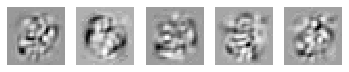

In [33]:
# Another technique for visualizing extracted features is that for each neuron in the first hidden layer,
# You can create an image where a pixel's intensity corresponds to the weight of the connection to the given neuron.

# The following code plots the features learned by five neurons in the first hidden layer:

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    weights1_val = weights1.eval()
    
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])
    
plt.savefig("extracted_features_plot")
plt.show()

# Unsupervised pretraining using stacked encoders

In [34]:
# If you are training a model for a complex task, but don't have alot of labeled training data,
# One solution is to find a similar model that was trained to do a similar task and reuse its lower layers.
    # This allows the training of a high performance model using only a small amount of training data.
    
# Similarly, if you have a large dataset, but most of it is unlabeled,
    # You can first train the autoencoder using all the data, reuse the lower layers of the model
    # And refine the model on the smaller amount of actual labeled training data that you have.
    

In [35]:
# Let's create a small neural network for MNIST classification:

reset_graph()

n_inputs= 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer= tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases2])
saver = tf.train.Saver()

In [36]:
# Regular training (without pretraining):

n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.97333336 Test accuracy: 0.9334
1 Train accuracy: 0.98 Test accuracy: 0.9359
2 Train accuracy: 0.97333336 Test accuracy: 0.9382
3 Train accuracy: 0.9866667 Test accuracy: 0.9495


In [37]:
# Now reusing the first two layers of the autoencoder we pretrained:

n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

# training_op = optimizer.minimize(loss, var_list=[weights3, biases3]) # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.9533333	Test accuracy 0.9352
1 Train accuracy: 0.99333334	Test accuracy 0.9362
2 Train accuracy: 0.9866667	Test accuracy 0.9497
3 Train accuracy: 0.97333336	Test accuracy 0.94


# Stacked Denoising Autoencoders

In [38]:
# Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs.

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [39]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu, name="hidden1")

hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")

hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")

outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [40]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [41]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.04405324
1 Train MSE: 0.043487985
2 Train MSE: 0.04195292
3 Train MSE: 0.041361865
4 Train MSE: 0.03988882
5 Train MSE: 0.03900992
6 Train MSE: 0.039403744
7 Train MSE: 0.042069178
8 Train MSE: 0.03997882
9 Train MSE: 0.040867157


In [42]:
# Using Dropout:

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [43]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [44]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict = {X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.029647598
1 Train MSE: 0.027554523
2 Train MSE: 0.025073143
3 Train MSE: 0.02543168
4 Train MSE: 0.024907619
5 Train MSE: 0.02505006
6 Train MSE: 0.024483003
7 Train MSE: 0.025150543
8 Train MSE: 0.024383636
9 Train MSE: 0.024234932


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


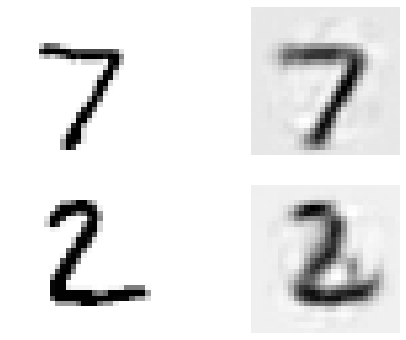

In [46]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

# Sparse Autoencoder

In [47]:
# A Sparse Autoencoder is another kind of restraint on the Machine Learning Algorithm that helps reduce the risk of overfitting.
# By adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer.
# This forces the autoencoder to represent each input as a combination of a small number of activations.
# As a result, each neuron in the coding layer typically ends up representing a useful feature.
# For example, if Activation of a neuron is measured at 0.3 but the target sparsity is 0.1, it must be penalized to activate less.
    # To do this, we use the Kullback-Leibler divergence, which has much stronger gradients than the Mean Squared Error.

In [48]:
# Now let's implement the Sparse Encoder using TensorFlow:

def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1, n_outputs)

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [49]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [50]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\Sparity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.06518411 \Sparity loss: 0.23175108 	Total loss: 0.11153433
1 Train MSE: 0.053680018 \Sparity loss: 0.0017892909 	Total loss: 0.054037876
2 Train MSE: 0.049760483 \Sparity loss: 0.044603564 	Total loss: 0.058681197
3 Train MSE: 0.043502253 \Sparity loss: 0.026536718 	Total loss: 0.048809595
4 Train MSE: 0.039597653 \Sparity loss: 0.004931858 	Total loss: 0.040584024
5 Train MSE: 0.0352226 \Sparity loss: 0.029756926 	Total loss: 0.041173987
6 Train MSE: 0.03121037 \Sparity loss: 0.014786402 	Total loss: 0.03416765
7 Train MSE: 0.028970387 \Sparity loss: 0.07858612 	Total loss: 0.04468761
8 Train MSE: 0.026001632 \Sparity loss: 0.025249243 	Total loss: 0.031051481
9 Train MSE: 0.023417281 \Sparity loss: 0.01110298 	Total loss: 0.025637876
10 Train MSE: 0.021957293 \Sparity loss: 0.015022063 	Total loss: 0.024961706
11 Train MSE: 0.021563184 \Sparity loss: 0.047494322 	Total loss: 0.031062048
12 Train MSE: 0.019964596 \Sparity loss: 0.07797282 	Total loss: 0.035559162
13 Tra

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


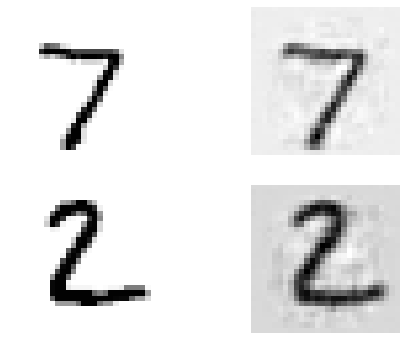

In [51]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

In [52]:
# Note that the coding layer must output values from 0 to 1, which is why we use the sigmoid activation function:

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)

In [53]:
# One simple trick to speed up convergence: instead of using the MSE, we can choose a reconstruction loss that will have larger gradients.
# Cross Entropy is often a good choice.
    # However we must normalize the inputs to make them take on values from 0 to 1.
    # Also, we use the logistic activation function in the output layer so the outputs also take on values from 0 to 1.
    
# Here is the code for this:

logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

# Variational Autoencoder

In [ ]:
# Variational autoencoders have 2 distinct differences from other autoencoders:
# First they are probabilistic autoencoders, meaning that their outputs are partly determined by chance even after training.
# Secondly, they are generative autoencoders, meaning that they can generate new instances that look like they were sampled from the training set.


In [54]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20 # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [55]:
# This is the code for the latent loss. 
# Latent loss pushes the variational autoencoder to have codings that look as though they were sampled from a simple Gaussian Distribution,
# for which we use the KL divergence between the target distribution and the actual distribution of the codings...

eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean) 
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [57]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [58]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 31208.12 	Reconstruction loss: 25653.162 	Latent loss: 5554.957
1 Train total loss: 28719.902 	Reconstruction loss: 23336.797 	Latent loss: 5383.1045
2 Train total loss: 29089.23 	Reconstruction loss: 21552.518 	Latent loss: 7536.713
3 Train total loss: 28208.57 	Reconstruction loss: 22170.035 	Latent loss: 6038.536
4 Train total loss: 23617.941 	Reconstruction loss: 20198.645 	Latent loss: 3419.2966
5 Train total loss: 25956.473 	Reconstruction loss: 19426.38 	Latent loss: 6530.091
6 Train total loss: 19874.336 	Reconstruction loss: 16766.828 	Latent loss: 3107.5076
7 Train total loss: 18754.873 	Reconstruction loss: 15735.596 	Latent loss: 3019.2778
8 Train total loss: 16921.139 	Reconstruction loss: 13865.1455 	Latent loss: 3055.9927
9 Train total loss: 16646.902 	Reconstruction loss: 13460.869 	Latent loss: 3186.0322
10 Train total loss: 16272.998 	Reconstruction loss: 13140.922 	Latent loss: 3132.0764
11 Train total loss: 17027.512 	Reconstruction loss: 13599.3

In [59]:
# The following code builds the variational autoencoder using log(sigma^2) variant:

reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20 # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver=tf.train.Saver()

# Generate Digits

In [60]:
# Now we will use the above variational autoencoder to generate images that look like handwritten digits.
# All we need to do is train the model, then sample random codings from a Gaussian distribution and then decode them:

import numpy as np

n_digits = 60
n_epochs = 50
batch_size=150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")
        
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 18234.959 	Reconstruction loss: 14613.555 	Latent loss: 3621.4038
1 Train total loss: 16910.785 	Reconstruction loss: 13154.402 	Latent loss: 3756.3826
2 Train total loss: 16619.904 	Reconstruction loss: 12762.092 	Latent loss: 3857.813
3 Train total loss: 16368.825 	Reconstruction loss: 12574.408 	Latent loss: 3794.417
4 Train total loss: 15873.08 	Reconstruction loss: 12050.129 	Latent loss: 3822.951
5 Train total loss: 16155.2295 	Reconstruction loss: 12337.519 	Latent loss: 3817.7107
6 Train total loss: 16276.033 	Reconstruction loss: 12419.353 	Latent loss: 3856.6812
7 Train total loss: 15712.37 	Reconstruction loss: 12033.814 	Latent loss: 3678.556
8 Train total loss: 15170.275 	Reconstruction loss: 11349.5 	Latent loss: 3820.775
9 Train total loss: 15865.42 	Reconstruction loss: 12077.842 	Latent loss: 3787.5781
10 Train total loss: 15799.446 	Reconstruction loss: 11909.492 	Latent loss: 3889.9543
11 Train total loss: 15461.79 	Reconstruction loss: 11676.518 

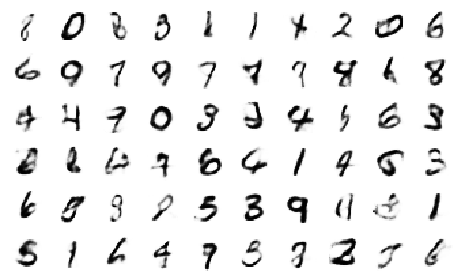

In [61]:
# That's it. Now we can see what the "handwritten" digits produced by the autoencoder look like:

plt.figure(figsize=(8, 50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

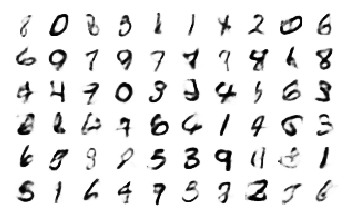

In [62]:
# Save the generated digits:

n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
plt.savefig("generated_digits_plot")
plt.show()

In [63]:
# Note that the latent loss is computed differently in this second variant:

latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

# Encode & Decode

In [64]:
# Encode:

n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


In [65]:
# Decode:

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


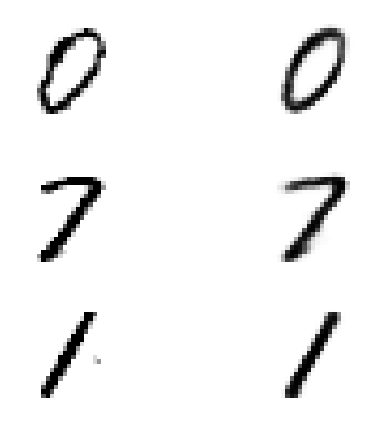

In [66]:
# Let's plot the reconstructions:

fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

# Interpolate digits

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


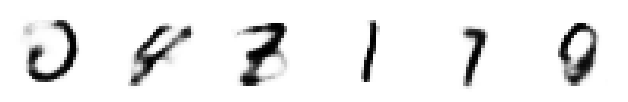

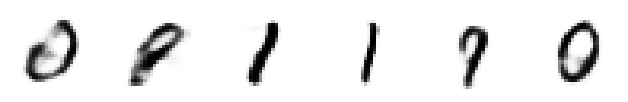

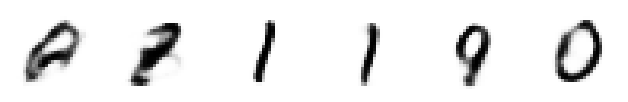

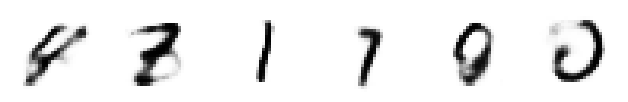

In [67]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()